In [18]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from scipy.interpolate import interp1d
from scipy.signal import butter, sosfiltfilt

In [31]:
path = '../dataset/revision/'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000

# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')

# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal

# butterworth filter
cutoff = 0.2
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'high', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,43.528,0.000183,-0.000043,-0.000126,0.000032,-1.448295,-0.022745,0.080793
1,43.529,0.000175,-0.000027,-0.000138,0.000032,-1.404318,-0.015839,0.073634
2,43.530,0.000168,-0.000012,-0.000149,0.000032,-1.361280,-0.009099,0.066641
3,43.531,0.000161,0.000003,-0.000161,0.000032,-1.319175,-0.002522,0.059813
4,43.532,0.000154,0.000018,-0.000172,0.000033,-1.277992,0.003892,0.053147
...,...,...,...,...,...,...,...,...
521995,565.523,0.000098,0.000060,0.000086,-0.000110,-0.181276,-0.092870,0.048521
521996,565.524,0.000091,0.000055,0.000079,-0.000102,-0.167487,-0.085754,0.044841
521997,565.525,0.000083,0.000050,0.000073,-0.000093,-0.153675,-0.078637,0.041156
521998,565.526,0.000076,0.000046,0.000066,-0.000085,-0.139840,-0.071520,0.037465


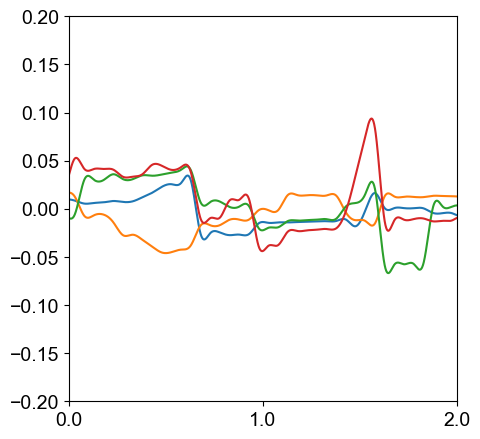

In [44]:
start = 293
length = 2

plt.figure(figsize=(5, 5))
plt.plot(high_res_df['timestamp'], high_res_df['pd1'], label='PD1')
plt.plot(high_res_df['timestamp'], high_res_df['pd2'], label='PD2')
plt.plot(high_res_df['timestamp'], high_res_df['pd3'], label='PD3')
plt.plot(high_res_df['timestamp'], high_res_df['pd4'], label='PD4')
# plt.plot(high_res_df['timestamp'], high_res_df['roll'])
# plt.plot(high_res_df['timestamp'], high_res_df['pitch'])
# plt.plot(high_res_df['timestamp'], high_res_df['yaw'])
plt.xlim(start, start + length)
plt.ylim(-0.2, 0.2)

plt.xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
plt.show()